# 1. Imports

In [46]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, Normalizer, Binarizer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import scipy.stats

pd.options.display.max_rows = 15
import warnings
warnings.filterwarnings('ignore')

# 2. Load Data

In [2]:
patient = pd.read_csv('../data/Patient_data_cleaned.csv')
patient.head()

,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,hospital_death,AgeGroup
0,68.0,22.73,0,Caucasian,M,180.3,Floor,admit,CTICU,0.541667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,0,60-80
1,77.0,27.42,0,Caucasian,F,160.0,Floor,admit,Med-Surg ICU,0.927778,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,0,60-80
2,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,admit,Med-Surg ICU,0.000694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,0,20-40
3,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,admit,CTICU,0.000694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,0,80-100
4,67.0,27.56,0,Caucasian,M,190.5,Accident & Emergency,admit,Med-Surg ICU,0.000694,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,0,60-80


# 3. Explore the Data

In [3]:
patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84026 entries, 0 to 84025
Data columns (total 80 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            80783 non-null  float64
 1   bmi                            81118 non-null  float64
 2   elective_surgery               84026 non-null  int64  
 3   ethnicity                      82852 non-null  object 
 4   gender                         84013 non-null  object 
 5   height                         82989 non-null  float64
 6   icu_admit_source               83941 non-null  object 
 7   icu_stay_type                  84026 non-null  object 
 8   icu_type                       84026 non-null  object 
 9   pre_icu_los_days               84026 non-null  float64
 10  weight                         81699 non-null  float64
 11  apache_2_diagnosis             83262 non-null  float64
 12  apache_3j_diagnosis            83778 non-null 

Check the object and int type of data if they are ordinal data

In [4]:
patient.select_dtypes(['object','int']).nunique()

elective_surgery          2
ethnicity                 6
gender                    2
icu_admit_source          5
icu_stay_type             3
icu_type                  8
apache_post_operative     2
apache_3j_bodysystem     11
hospital_death            2
AgeGroup                  5
dtype: int64

In [5]:
col_list=patient.select_dtypes(['object','int']).columns

In [6]:
for col in col_list:
    value_counts=patient[col].value_counts()
    print(value_counts) 

elective_surgery
0    68424
1    15602
Name: count, dtype: int64
ethnicity
Caucasian           64792
African American     8647
Other/Unknown        4086
Hispanic             3552
Asian                1027
Native American       748
Name: count, dtype: int64
gender
M    45357
F    38656
Name: count, dtype: int64
icu_admit_source
Accident & Emergency         49878
Operating Room / Recovery    17289
Floor                        14024
Other Hospital                2203
Other ICU                      547
Name: count, dtype: int64
icu_stay_type
admit       79103
transfer     4479
readmit       444
Name: count, dtype: int64
icu_type
Med-Surg ICU    46058
MICU             7294
Neuro ICU        7061
CCU-CTICU        6449
SICU             4908
CSICU            4396
Cardiac ICU      4339
CTICU            3521
Name: count, dtype: int64
apache_post_operative
0    67003
1    17023
Name: count, dtype: int64
apache_3j_bodysystem
Cardiovascular          27348
Neurological            11048
Sepsis        

We can see that only the AgeGroup is the ordinal feature and we should apply label encoding on this column and apply one hot encoding on the rest categorical features.

# 4. Training Testing Split

In [7]:
X=patient.drop('hospital_death', axis=1)
y=patient[['hospital_death']]

Let's do the train/test split.

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=12)

From the EAD we did, we know that this dataset is supper unbanlanced, the target variable have large amount of 0. To make sure our model works well, we need to resample the data before the tarining testing split.

In [9]:
# use random oversampling to resample the data
from imblearn.over_sampling import RandomOverSampler

# Apply random oversampling to balance the classes
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)


lets check if y_train is balanced

In [10]:
y_train.value_counts()

hospital_death
0                 61770
1                 61770
Name: count, dtype: int64

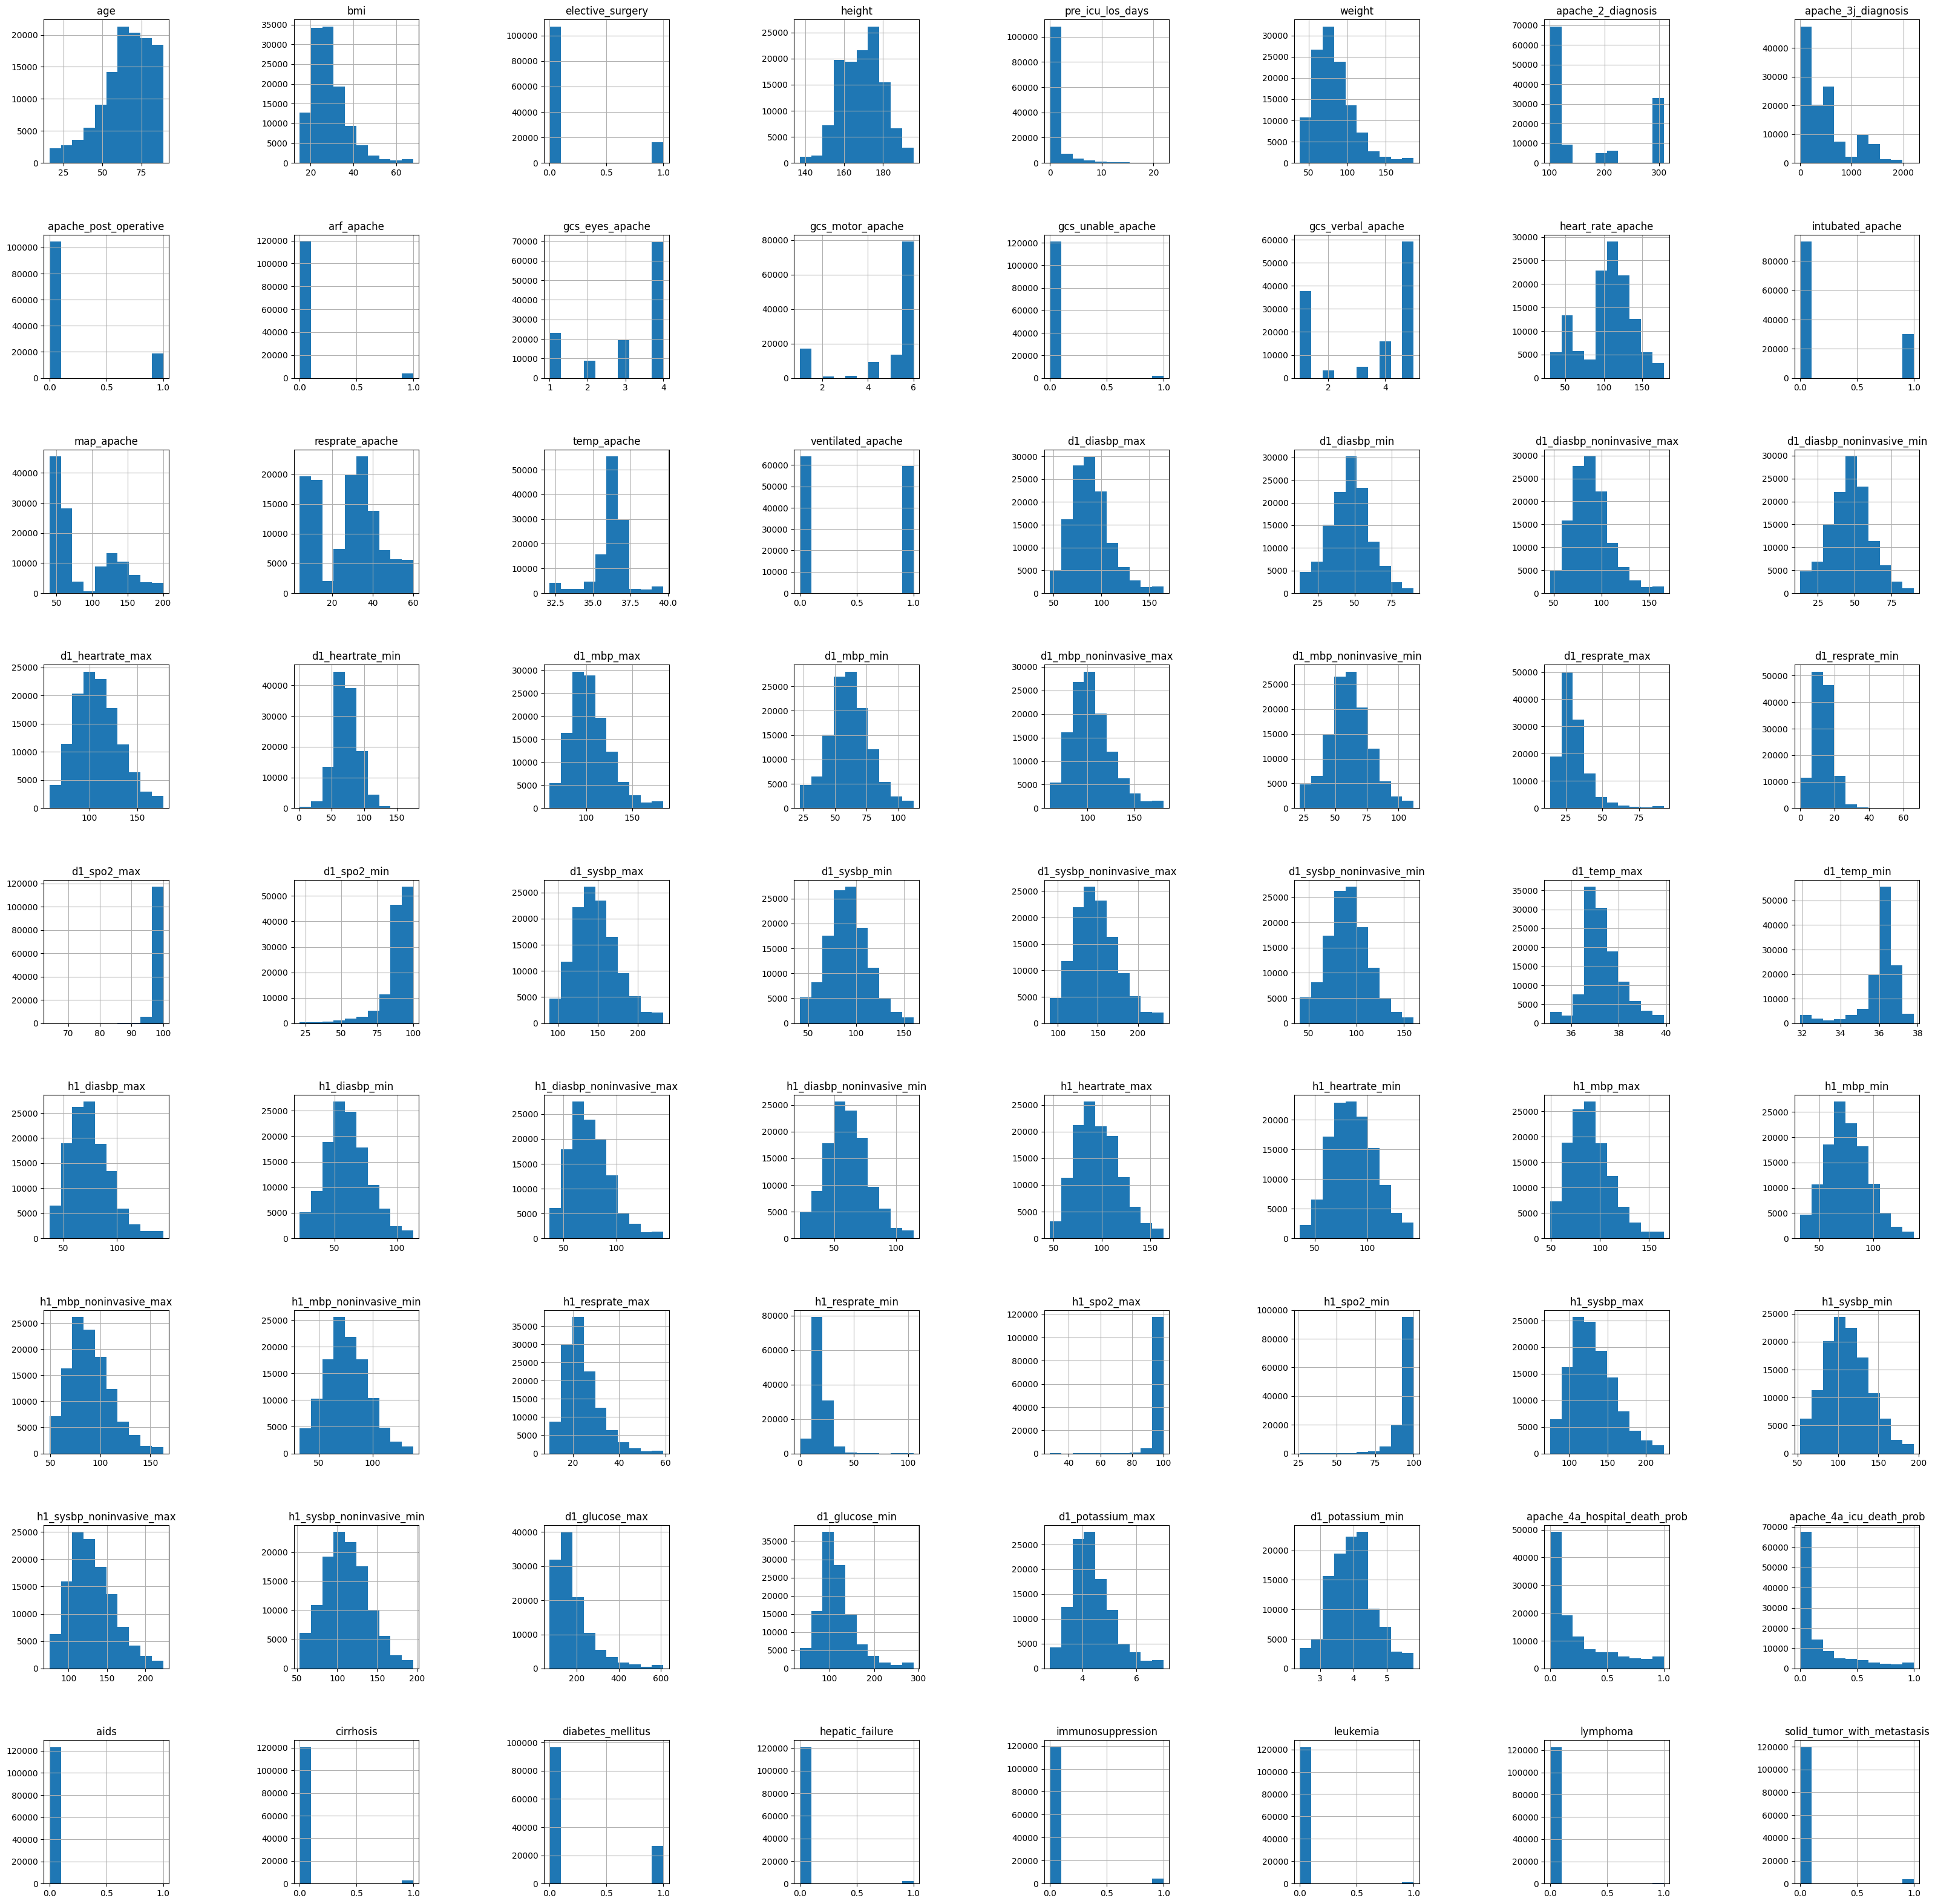

In [11]:
#Check the distrbution of features
X_train.hist(figsize=(40,40))
plt.subplots_adjust(wspace=1,hspace=0.5);

# 5 Missing values
I fill the missing values based on following rules:
When the missing values are numerical and the distribution of the variable is approximately normal, I fill with mean.
When the distribution is skewed, I fill with median.
When the feature is categorical variables or numerical variables with a small number of unique values, I fill with mode.

## 5.1 Fill the gender randomly 

In [12]:
#fill gender
X_train['gender'].fillna(method='bfill')
X_test['gender'].fillna(method='bfill')

62903    F
15088    M
82298    F
75665    M
54757    F
        ..
38722    M
63796    M
21514    M
69095    F
82404    F
Name: gender, Length: 16806, dtype: object

## 5.2 Fill data with approximately normal distribution with mean.

the weight and height distribution are approximately normal, so we use mean to fill the na, but it do affected by gender, so we use gender to group.

In [13]:
#fill weight based on the gender for the Training set
X_train.loc[X_train['gender']=='F',"weight"]\
=X_train.loc[X_train['gender']=='F',"weight"].\
fillna(value=X_train.loc[X_train['gender']=='F',"weight"].mean())
#fill weight based on the gender for the Testing set
X_test.loc[X_test['gender']=='F',"weight"]\
=X_test.loc[X_test['gender']=='F',"weight"].\
fillna(value=X_train.loc[X_train['gender']=='F',"weight"].mean())

#fill weight based on the gender for the Training set
X_train.loc[X_train['gender']=='M',"weight"]\
=X_train.loc[X_train['gender']=='M',"weight"].\
fillna(value=X_train.loc[X_train['gender']=='M',"weight"].mean())
#fill weight based on the gender for the Testing set
X_test.loc[X_test['gender']=='M',"weight"]\
=X_test.loc[X_test['gender']=='M',"weight"].\
fillna(value=X_train.loc[X_train['gender']=='M',"weight"].mean())

In [14]:
#fill Height based on the gender for the Training set
X_train.loc[X_train['gender']=='F',"height"]\
=X_train.loc[X_train['gender']=='F',"height"].\
fillna(value=X_train.loc[X_train['gender']=='F',"height"].mean())
#fill Height based on the gender for the Testing set
X_test.loc[X_test['gender']=='F',"height"]\
=X_test.loc[X_test['gender']=='F',"height"].\
fillna(value=X_train.loc[X_train['gender']=='F',"height"].mean())

#fill Height based on the gender for the Training set
X_train.loc[X_train['gender']=='M',"height"]\
=X_train.loc[X_train['gender']=='M',"height"].\
fillna(value=X_train.loc[X_train['gender']=='M',"height"].mean())
#fill Height based on the gender for the Testing set
X_test.loc[X_test['gender']=='M',"height"]\
=X_test.loc[X_test['gender']=='M',"height"].\
fillna(value=X_train.loc[X_train['gender']=='M',"height"].mean())

In [15]:
#calculate bmi
X_train['bmi']= X_train['weight']/(X_train['height']/100)**2
X_test['bmi']= X_test['weight']/(X_test['height']/100)**2

In [16]:
numerical=X_train.loc[:,X_train.nunique()>11]
#fillter those features based on skewness.
skewness_data =numerical.agg(['skew', 'kurtosis']).transpose()
feature_skew = skewness_data[(skewness_data['skew'] > 1)|(skewness_data['skew'] <-1)].index.tolist()
feature_norm = skewness_data[(skewness_data['skew'] < 1)|(skewness_data['skew'] >-1)].index.tolist()

In [17]:
#fill other roughly numerical data with mean
X_train[feature_norm]=X_train[feature_norm].fillna(X_train[feature_norm].mean())
X_test[feature_norm]=X_test[feature_norm].fillna(X_train[feature_norm].mean())

## 5.3 Fill other skewed numerical data with median

In [18]:
X_train[feature_skew]=X_train[feature_skew].fillna(X_train[feature_skew].median())
X_test[feature_skew]=X_test[feature_skew].fillna(X_train[feature_skew].median())

## 5.4 Fill categorical data with mode

In [19]:
cate=X_train.loc[:,X_train.nunique()<12]
col_to_fill=cate.columns.tolist()
for col in col_to_fill:
    mode = X_train[col].mode()[0]
    X_train[col].fillna(mode, inplace=True)

In [20]:
for col in col_to_fill:
    mode = X_train[col].mode()[0]
    X_test[col].fillna(mode, inplace=True)

Check if there still have NAs

In [21]:
X_train.isnull().sum()

age                            0
bmi                            0
elective_surgery               0
ethnicity                      0
gender                         0
                              ..
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
AgeGroup                       0
Length: 79, dtype: int64

# 6. Feature Engineering

## 6.1 Label Encoding
For the AgeGroup column, we use label encoding to transform the original categorical feature into a group of number.

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Apply label encoding to AgeGroup column in the list
X_train['Age_group_encoded'] = label_encoder.fit_transform(X_train['AgeGroup'])
X_train=X_train.drop('AgeGroup',axis=1)
X_test['Age_group_encoded'] = label_encoder.fit_transform(X_test['AgeGroup'])
X_test=X_test.drop('AgeGroup',axis=1)

## 6.2 One hot Encoding
We use one-hot encoding to transform the rest of the categorical features.

In [23]:
#columns need to be encoded
col_list=col_list.tolist()
col_list.remove('AgeGroup')
col_list.remove('hospital_death')

In [24]:
X_train=pd.get_dummies(X_train, columns=col_list, prefix=col_list, drop_first=True, dtype=int)
X_test=pd.get_dummies(X_test, columns=col_list, prefix=col_list, drop_first=True, dtype=int)

## 6.3 Log Transformations

Some of the features are super skew. So we might need to do log transformations to these features.
Lets check the skewness of the features.

In [25]:
non_binary_features_names = X_train.columns[X_train.nunique() > 2].tolist()
non_binary_features=X_train[non_binary_features_names]

Log transformation for the features that have positive skewness 

In [26]:
skewness_data =non_binary_features.agg(['skew', 'kurtosis']).transpose()
#fillter those features that have a skewness larger than 1.
log_features = skewness_data[(skewness_data['skew'] > 1)]
selected_feature_names = log_features.index.tolist()
selected_features = X_train[selected_feature_names]
# Apply the log transformation to the selected features
X_train[selected_feature_names] = X_train[selected_feature_names].apply(lambda x: np.log1p(x))
X_test[selected_feature_names] = X_test[selected_feature_names].apply(lambda x: np.log1p(x))

Log transformation for the features that have negtive skewness 

In [27]:
log_features_neg = skewness_data[(skewness_data['skew'] < -1)]
selected_feature_names_neg = log_features_neg.index.tolist()
selected_features_neg = X_train[selected_feature_names_neg]
# Apply the log transformation to the selected features
X_train[selected_feature_names_neg] = X_train[selected_feature_names_neg].apply(lambda x: np.log1p(x))
X_test[selected_feature_names] = X_test[selected_feature_names].apply(lambda x: np.log1p(x))

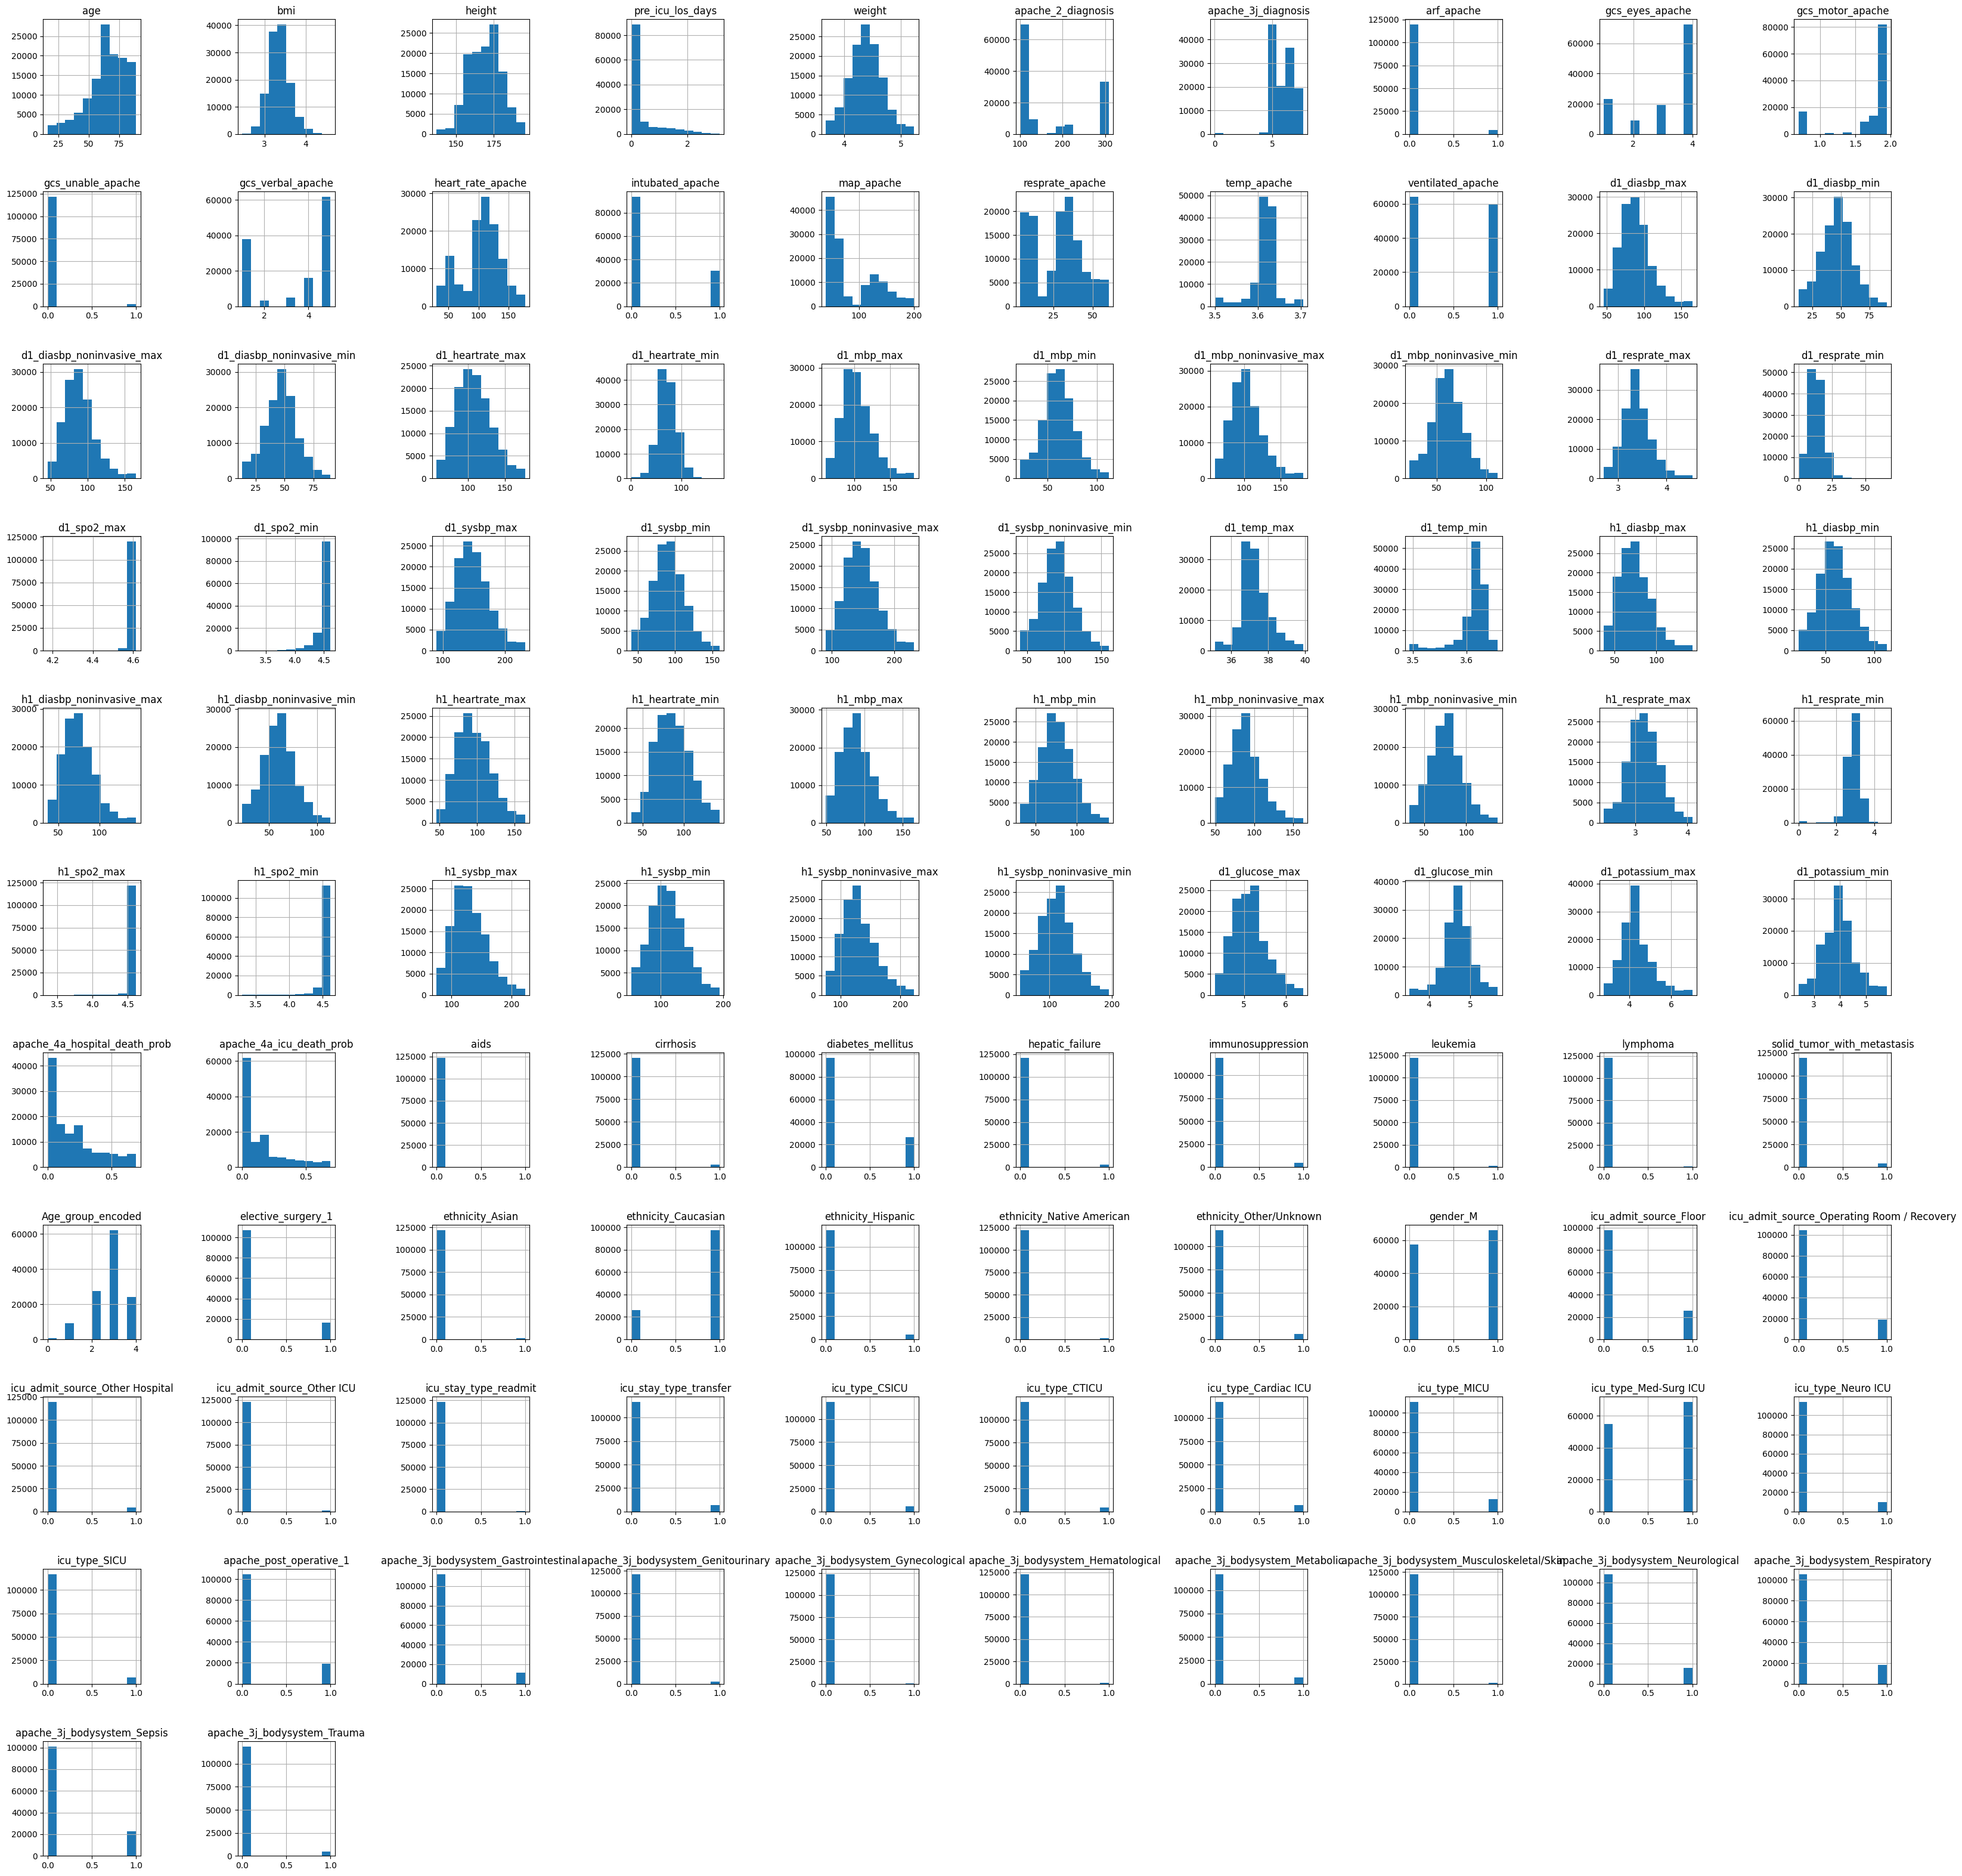

In [28]:
#Check the distrbution of features again
X_train.hist(figsize=(40,40))
plt.subplots_adjust(wspace=1,hspace=0.5);

some of the features looks better now.

# 7. Modeling

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from bayes_opt import BayesianOptimization
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

## 7.1 Logistic Regression

### 7.1.1 Model with out scaling the data

In [301]:
lr=LogisticRegression(random_state=12)
lr.fit(X_train, y_train.hospital_death)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred1)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9203260740211829
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     15428
           1       0.72      0.05      0.09      1378

    accuracy                           0.92     16806
   macro avg       0.82      0.52      0.52     16806
weighted avg       0.90      0.92      0.89     16806



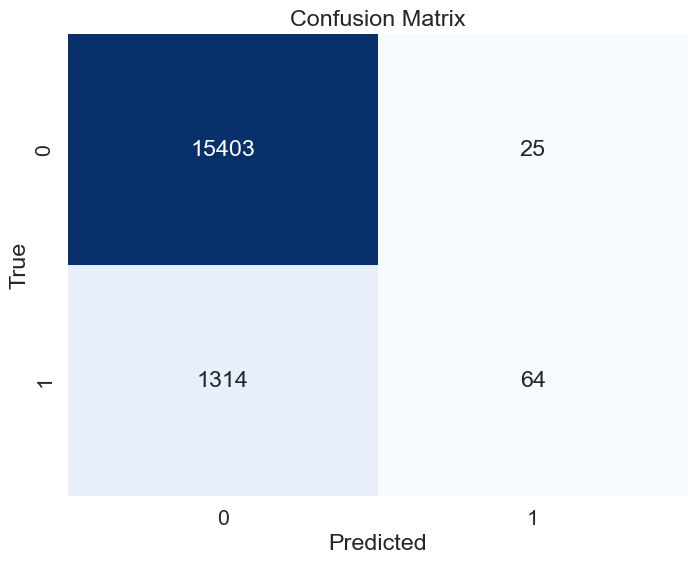

In [302]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Adjust the font scale for readability

# Use seaborn's heatmap to plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])

# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('True')

# Add a title
plt.title('Confusion Matrix')

# Show the plot
plt.show()

### 7.1.2 Use pipeline and add a scaler first

In [308]:
#pipeline with Standardlize scaler
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('lr', LogisticRegression(random_state=12))], 
                     )
#Fit the training data
pipe.fit(X_train, y_train.hospital_death)
y_pred = pipe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9180054742353921
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     15428
           1       0.00      0.00      0.00      1378

    accuracy                           0.92     16806
   macro avg       0.46      0.50      0.48     16806
weighted avg       0.84      0.92      0.88     16806



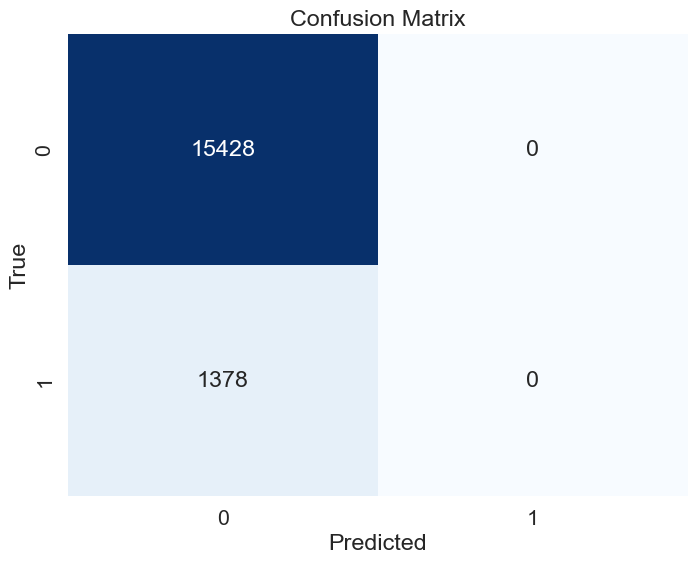

In [309]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Adjust the font scale for readability
# Use seaborn's heatmap to plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('True')
# Add a title
plt.title('Confusion Matrix')
# Show the plot
plt.show()

In [315]:
#pipeline use normalizer
pipe1 = Pipeline(steps=[('scaler', Normalizer()), 
                       ('lr', LogisticRegression(random_state=12))], 
                     )
#Fit the training data
pipe1.fit(X_train, y_train.hospital_death)
y_pred = pipe1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.6401285255265976
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.63      0.76     15428
           1       0.16      0.78      0.26      1378

    accuracy                           0.64     16806
   macro avg       0.56      0.71      0.51     16806
weighted avg       0.90      0.64      0.72     16806



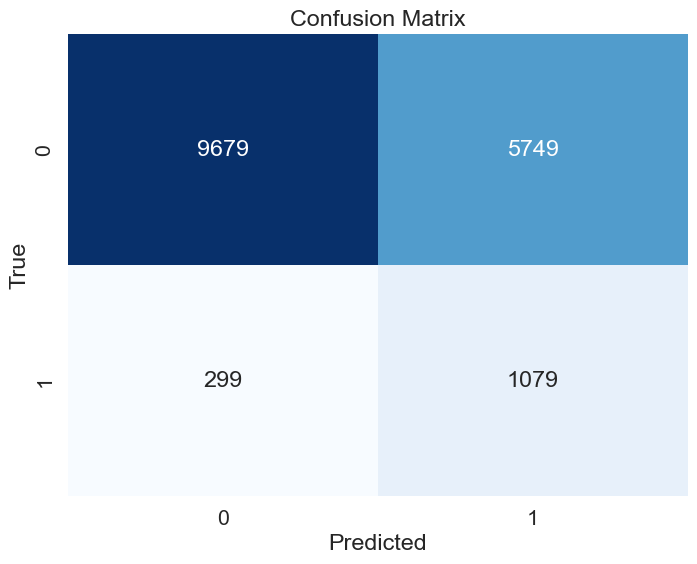

In [316]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Adjust the font scale for readability
# Use seaborn's heatmap to plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('True')
# Add a title
plt.title('Confusion Matrix')
# Show the plot
plt.show()

From the result we can tell standarlize the data make the model even worse. Normalize the data kind of improve the model.

### 7.1.3 Use random search to optimize the model

In [317]:
# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'lr__penalty': ['l1', 'l2'], 
    'lr__max_iter': [100, 200, 300]
}
random_search = RandomizedSearchCV(pipe1, param_distributions=param_grid, n_iter=50, cv=5, scoring='recall_macro', random_state=12)
# Perform the randomized search
random_search.fit(X_train, y_train.hospital_death)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', Normalizer()),
                                             ('lr',
                                              LogisticRegression(random_state=12))]),
                   n_iter=50,
                   param_distributions={'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'lr__max_iter': [100, 200, 300],
                                        'lr__penalty': ['l1', 'l2']},
                   random_state=12, scoring='recall_macro')

In [318]:
# Get the best hyperparameters and the best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Parameters:", best_params)
print("Accuracy:", accuracy)
print("Best Model's Mean Cross-Validation Score:", random_search.best_score_)
print("Classification Report:\n", report)

Best Parameters: {'lr__penalty': 'l2', 'lr__max_iter': 300, 'lr__C': 100}
Accuracy: 0.9227061763655837
Best Model's Mean Cross-Validation Score: 0.7550590901732233
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     15428
           1       0.63      0.14      0.23      1378

    accuracy                           0.92     16806
   macro avg       0.78      0.57      0.59     16806
weighted avg       0.90      0.92      0.90     16806



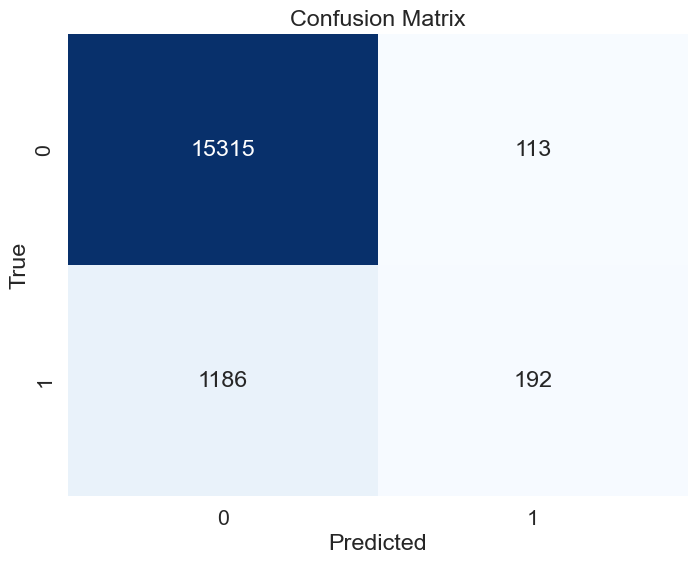

In [319]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Adjust the font scale for readability
# Use seaborn's heatmap to plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('True')
# Add a title
plt.title('Confusion Matrix')
# Show the plot
plt.show()

Although this model have a decent accuracy, but it predicte 0 most time, so it's a very pool model. We'd better try some other models.

## 7.2 Naive Bayes
### 7.2.1 Default model

In [475]:
#Use the Bernoulli naive bayes
from sklearn.naive_bayes import BernoulliNB

nb=BernoulliNB()
nb.fit(X_train, y_train.hospital_death)
y_pred = nb.predict(X_test)
y_trainpred = nb.predict(X_train)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train=accuracy_score(y_train, y_trainpred)
report = classification_report(y_test, y_pred)
#print out the result
print("Accuracy:", accuracy_test)
print("Train Accuracy:",accuracy_train)
print("Classification Report:\n", report)

Accuracy: 0.7101630370105915
Train Accuracy: 0.7196778371377691
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.71      0.82     15428
           1       0.18      0.74      0.29      1378

    accuracy                           0.71     16806
   macro avg       0.58      0.72      0.56     16806
weighted avg       0.90      0.71      0.77     16806



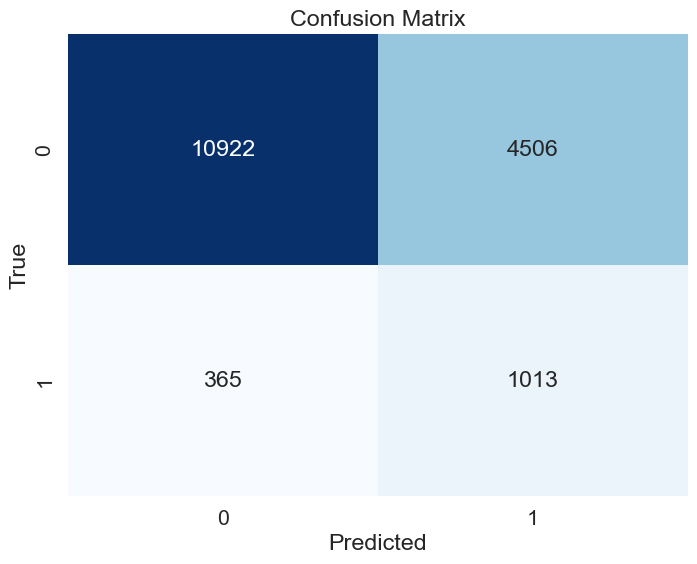

In [447]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Adjust the font scale for readability
# Use seaborn's heatmap to plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('True')
# Add a title
plt.title('Confusion Matrix')
# Show the plot
plt.show()

### 7.2.2 Add scaler

In [472]:
pipe = Pipeline(steps=[('scaler', MinMaxScaler()), 
                       ('nb', BernoulliNB())] 
                     )
pipe.fit(X_train, y_train.hospital_death)
y_pred = pipe.predict(X_test)
y_trainpred = pipe.predict(X_train)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train=accuracy_score(y_train, y_trainpred)
report = classification_report(y_test, y_pred)

print("Test Accuracy:", accuracy_test)
print("Train Accuracy:",accuracy_train)
print("Classification Report:\n", report)

Test Accuracy: 0.8588599309770321
Train Accuracy: 0.7437995790836975
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92     15428
           1       0.30      0.53      0.38      1378

    accuracy                           0.86     16806
   macro avg       0.63      0.71      0.65     16806
weighted avg       0.90      0.86      0.88     16806



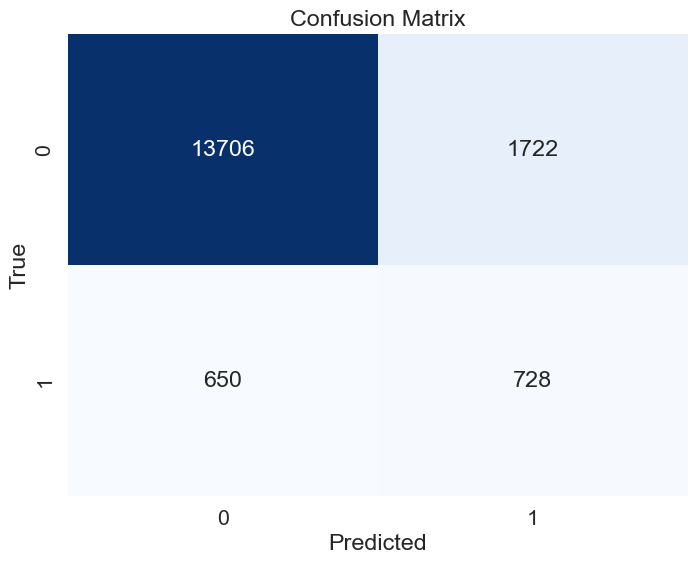

In [473]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Adjust the font scale for readability
# Use seaborn's heatmap to plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('True')
# Add a title
plt.title('Confusion Matrix')
# Show the plot
plt.show()

Scaler seems not working well on this model as well.

### 7.2.3 Hyperparametters tuning-Random Search 

In [485]:
nb=BernoulliNB()
param_grid = {
    'binarize': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'alpha': [10,1, 0.1, 0.01, 0.001]
}

random_search = RandomizedSearchCV(nb, param_distributions=param_grid, n_iter=50, cv=5, scoring='f1_macro', random_state=12)
# Perform the randomized search
random_search.fit(X_train, y_train.hospital_death)


RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_iter=50,
                   param_distributions={'alpha': [10, 1, 0.1, 0.01, 0.001],
                                        'binarize': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5]},
                   random_state=12, scoring='f1_macro')

In [486]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_
y_pred = best_model.predict(X_test)
y_trainpred = best_model.predict(X_train)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train= accuracy_score(y_train, y_trainpred)
report = classification_report(y_test, y_pred)

print("Best Parameters:", best_params)
print("Accuracy:", accuracy_test)
print("Train Accuracy:",accuracy_train)
print("Best Model's Mean Cross-Validation Score:", best_score)
print("Classification Report:\n", report)

Best Parameters: {'binarize': 0.1, 'alpha': 0.01}
Accuracy: 0.7620492681185291
Train Accuracy: 0.7494495709891533
Best Model's Mean Cross-Validation Score: 0.7573255625708273
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.76      0.86     15428
           1       0.22      0.74      0.34      1378

    accuracy                           0.76     16806
   macro avg       0.59      0.75      0.60     16806
weighted avg       0.91      0.76      0.81     16806



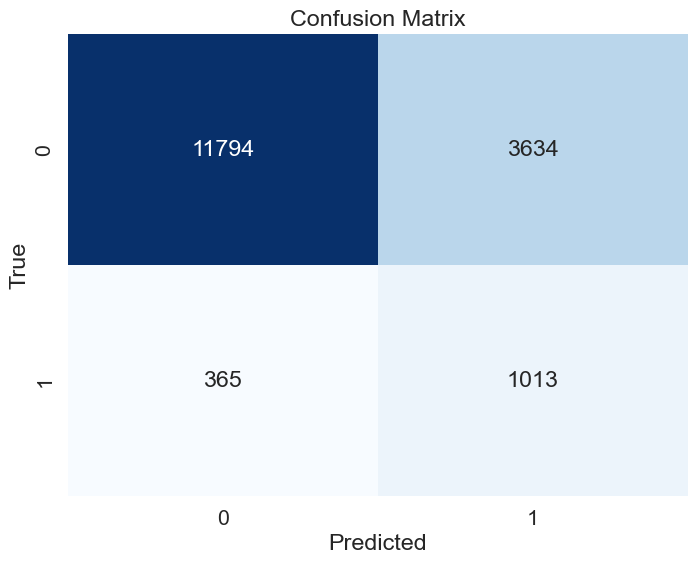

In [487]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Adjust the font scale for readability
# Use seaborn's heatmap to plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('True')
# Add a title
plt.title('Confusion Matrix')
# Show the plot
plt.show()

This model perform better than the logistic regression model, but it still not working well on predict the 1 value. And this model are too simple so there is underfitting problem. 

## 7.3 K-Nearest Neighbors


In [510]:
from sklearn.neighbors import KNeighborsClassifier
knn= KNeighborsClassifier(weights='distance')
param_dist = {
    'n_neighbors': np.arange(1, 11)
}
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy')
random_search.fit(X_train, y_train.hospital_death)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(weights='distance'),
                   param_distributions={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
                   scoring='accuracy')

In [511]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_
y_pred = best_model.predict(X_test)
y_trainpred = best_model.predict(X_train)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train= accuracy_score(y_train, y_trainpred)
report = classification_report(y_test, y_pred)

print("Best Parameters:", best_params)
print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Best Model's Mean Cross-Validation Score:", best_score)
print("Classification Report:\n", report)

Best Parameters: {'n_neighbors': 1}
Train Accuracy: 1.0
Test Accuracy: 0.8781387599666786
Best Model's Mean Cross-Validation Score: 0.9647644487615347
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93     15428
           1       0.18      0.14      0.16      1378

    accuracy                           0.88     16806
   macro avg       0.55      0.54      0.55     16806
weighted avg       0.86      0.88      0.87     16806



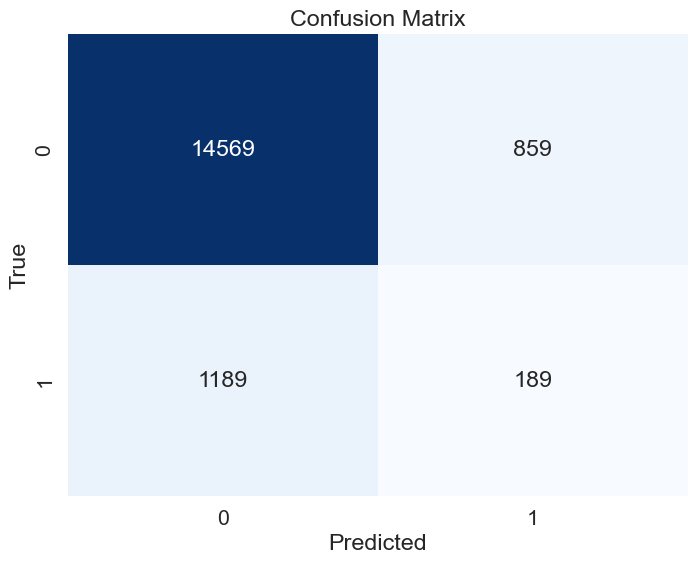

In [509]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Adjust the font scale for readability
# Use seaborn's heatmap to plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('True')
# Add a title
plt.title('Confusion Matrix')
# Show the plot
plt.show()

Knn is not a good model for this data set.

## 7.4 Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


### 7.4.1 Default model

In [42]:
rf=RandomForestClassifier()
rf.fit(X_train, y_train.hospital_death)

RandomForestClassifier(n_estimators=1000, random_state=12)

In [41]:
y_pred = rf.predict(X_test)
y_trainpred = rf.predict(X_train)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train=accuracy_score(y_train, y_trainpred)
report = classification_report(y_test, y_pred)
mae_train=mean_absolute_error(y_train, y_trainpred)
mae_test=mean_absolute_error(y_test, y_pred)
#print out the result
print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Train MAE:",mae_train)
print("Test MAE:", mae_test)
print("Classification Report:\n", report)


Train Accuracy: 1.0
Test Accuracy: 0.9180054742353921
Train MAE: 0.0
Test MAE: 0.08199452576460788
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     15428
           1       0.00      0.00      0.00      1378

    accuracy                           0.92     16806
   macro avg       0.46      0.50      0.48     16806
weighted avg       0.84      0.92      0.88     16806



Althrough have a high accuracy, The default model did not predict the 1 value.

### 7.4.2 Hyperparametter Tuning

In [38]:
rf = RandomForestClassifier(random_state=12)
param_dist = {
        'n_estimators': (5,150),
        #'max_features': ['sqrt', 'log2',None],
        'max_depth': (2,90),
        'min_samples_split': (2,10),
        'min_samples_leaf': (1,7)
    }
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1_macro')
random_search.fit(X_train, y_train.hospital_death)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12),
                   param_distributions={'max_depth': (2, 90),
                                        'min_samples_leaf': (1, 7),
                                        'min_samples_split': (2, 10),
                                        'n_estimators': (5, 150)},
                   scoring='f1_macro')

In [39]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_
y_pred = best_model.predict(X_test)
y_trainpred = best_model.predict(X_train)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train= accuracy_score(y_train, y_trainpred)
mae_train=mean_absolute_error(y_train, y_trainpred)
mae_test=mean_absolute_error(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best Model's Mean Cross-Validation Score:", best_score)
print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Train MAE:",mae_train)
print("Test MAE:", mae_test)
print("Classification Report:\n", report)


Best Parameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 90}
Best Model's Mean Cross-Validation Score: 0.9900589081625254
Train Accuracy: 1.0
Test Accuracy: 0.9180054742353921
Train MAE: 0.0
Test MAE: 0.08199452576460788
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     15428
           1       0.00      0.00      0.00      1378

    accuracy                           0.92     16806
   macro avg       0.46      0.50      0.48     16806
weighted avg       0.84      0.92      0.88     16806



Tune the hyperparametters did not improve the model. So, random forest is not a suitble model for this dataset.

## 7.5 Support Vector Machines
### 7.5.1 Default Model

In [43]:

from sklearn.svm import SVC
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('svc', SVC())] 
                     )
pipe.fit(X_train, y_train.hospital_death)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

In [44]:
y_pred = pipe.predict(X_test)
y_trainpred = pipe.predict(X_train)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train=accuracy_score(y_train, y_trainpred)
mae_train=mean_absolute_error(y_train, y_trainpred)
mae_test=mean_absolute_error(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Train MAE:",mae_train)
print("Test MAE:", mae_test)
print("Classification Report:\n", report)


Train Accuracy: 0.9326857697911608
Test Accuracy: 0.9180054742353921
Train MAE: 0.06731423020883924
Test MAE: 0.08199452576460788
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     15428
           1       0.00      0.00      0.00      1378

    accuracy                           0.92     16806
   macro avg       0.46      0.50      0.48     16806
weighted avg       0.84      0.92      0.88     16806



 ### 7.5.2 Hyperparametter Tuning

In [ ]:
param_dist = {
    'svc__C': scipy.stats.expon(scale=1),
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__degree': scipy.stats.randint(2, 5),
    'svc__gamma': scipy.stats.expon(scale=0.1)
}
random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1_macro', random_state=12)
random_search.fit(X_train, y_train.hospital_death)

In [ ]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_
y_pred = best_model.predict(X_test)
y_trainpred = best_model.predict(X_train)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train= accuracy_score(y_train, y_trainpred)
mae_train=mean_absolute_error(y_train, y_trainpred)
mae_test=mean_absolute_error(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best Model's Mean Cross-Validation Score:", best_score)
print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Train MAE:",mae_train)
print("Test MAE:", mae_test)
print("Classification Report:\n", report)

# 8 Model Selection

I tried five classification models. Logistic Regression, Random Forest and SVC have the highest accuracy, but Regression, Random Forest and SVC only predict the ‘0’ value of the target variable. Logistic Regression have a very high accuracy but perform pool on predicting the ‘1’ value. The Bernoulli Naïve Bayes model has the lowest accuracy, but it works better on predicting the ‘1’ value. Since our target is predicting if the patient will survive or not, value ‘1’ stands for the death of the patient. So, it’s crucial that our model can predict the death of the patient. So, based on the results, I will choose the Bernoulli Naïve Bayes model although it’s accuracy is lower than other models.